Deep Learning Assignment 3 - Stock Price Prediction With RNN

References:
Code source 1: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

Code source 2 (TODO: find how to get predictions accuracy): https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch


In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import torch
import torch.nn as nn
import os
import yfinance as yf
import os, contextlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
# File Download 
offset = 0
limit = 3000
period = 'max' # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
symbols = ['AAPL','AMZN','META']
limit = limit if limit else len(symbols)
end = min(offset + limit, len(symbols))
is_valid = [False] * len(symbols)
# force silencing of verbose API
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        for i in range(offset, end):
            s = symbols[i]
            data = yf.download(s, period=period)
            if len(data.index) == 0:
                continue
        
            is_valid[i] = True
            file_name = s + ".csv"
            # download_path = os.path.join(root_dir,file_name)
            data.to_csv(file_name)

print('Total number of valid symbols downloaded = {}'.format(sum(is_valid)))

Total number of valid symbols downloaded = 3


In [56]:
MIN_MAX_SCALING = "min_max_scaling"
STANDARD_SCALING = "standard_scaling"
ADJACENT_CLOSE = "Adj Close"
OPEN = "Open"
def get_scaler(scaling_method):
    data_scaler = None
    if scaling_method == MIN_MAX_SCALING:
        data_scaler = MinMaxScaler(feature_range=(-1, 1))
    elif scaling_method == STANDARD_SCALING:
        data_scaler = StandardScaler()
    else:
        raise Exception("Invalid Scaling method ", scaling_method)

    return data_scaler

def get_data(file_name, scaling_method):
    data = pd.read_csv(file_name, index_col='Date')
    price_close = data[[ADJACENT_CLOSE]]
    price_open = data[[OPEN]]

    data_scaler = get_scaler(scaling_method)
    
    price_close[ADJACENT_CLOSE] = data_scaler.fit_transform(price_close[ADJACENT_CLOSE].values.reshape(-1,1))
    price_open[OPEN] = data_scaler.fit_transform(price_open[OPEN].values.reshape(-1,1))

    return price_open, price_close, data_scaler


In [17]:

price_open_min_max, price_close_min_max = get_data('AMZN.csv', MIN_MAX_SCALING)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
price_open_min_max

,Open
Date,
1997-05-15,-0.999449
1997-05-16,-0.999699
1997-05-19,-0.999811
1997-05-20,-0.999827
1997-05-21,-0.999878
...,...
2022-11-10,-0.007430
2022-11-11,0.045368
2022-11-14,0.054880


In [19]:
price_close_min_max

,Adj Close
Date,
1997-05-15,-0.999698
1997-05-16,-0.999821
1997-05-19,-0.999832
1997-05-20,-0.999872
1997-05-21,-0.999983
...,...
2022-11-10,0.035494
2022-11-11,0.080105
2022-11-14,0.055441


In [20]:
price_open_standard, price_close_standard = get_data('AMZN.csv', STANDARD_SCALING)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
price_open_standard

,Open
Date,
1997-05-15,-0.638990
1997-05-16,-0.639480
1997-05-19,-0.639698
1997-05-20,-0.639731
1997-05-21,-0.639829
...,...
2022-11-10,1.301840
2022-11-11,1.405135
2022-11-14,1.423745


In [22]:
price_close_standard

,Adj Close
Date,
1997-05-15,-0.639720
1997-05-16,-0.639960
1997-05-19,-0.639982
1997-05-20,-0.640058
1997-05-21,-0.640276
...,...
2022-11-10,1.380392
2022-11-11,1.467448
2022-11-14,1.419316


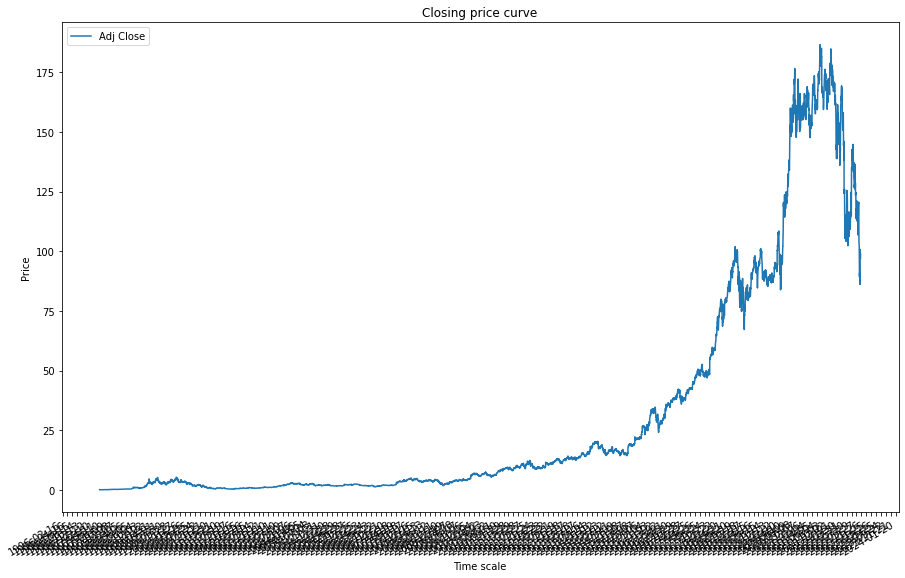

In [26]:
stock_data_raw = pd.read_csv('AMZN.csv', index_col='Date')
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data_raw.index.values]

plt.plot(x_dates, stock_data_raw[ADJACENT_CLOSE], label=ADJACENT_CLOSE)
# plt.plot(x_dates, data['Low'], label='Low')
plt.xlabel('Time scale')
plt.ylabel('Price')
plt.title('Closing price curve')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [30]:
def convert_to_torch_tensor(numpy_data):
    return torch.from_numpy(numpy_data).type(torch.Tensor)


def split_data(X, y, test_size, lookback):
    X_raw = X.to_numpy() # convert to numpy array
    y_raw = y.to_numpy()
    X_data = []
    y_data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(X_raw) - lookback): 
        X_data.append(X_raw[index: index + lookback])
        y_data.append(y_raw[index: index + lookback])
    
    X_data = np.array(X_data);
    y_data = np.array(y_data)
    train_set_size = X_data.shape[0] - (test_size)
    
    X_train_val = X_data[:train_set_size,:-1,:]
    y_train_val = y_data[:train_set_size,-1,:]
    
    X_test = X_data[train_set_size:,:-1]
    y_test = y_data[train_set_size:,-1,:]

    # split train into validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, )

    X_train = convert_to_torch_tensor(X_train)
    X_val = convert_to_torch_tensor(X_val)
    X_test = convert_to_torch_tensor(X_test)
    y_train = convert_to_torch_tensor(y_train)
    y_val = convert_to_torch_tensor(y_val)
    y_test = convert_to_torch_tensor(y_test)
    
    return [X_train, X_val, X_test, y_train, y_val, y_test]


In [58]:
def inverse_transform_data(data, data_scaler):
    data_copy = data.clone()
    return data_scaler.inverse_transform(data_copy.detach().numpy())

def calculate_prediction_error(X, y, model, data_scaler):
    y_pred = model(X)
    #invert predictions
    y_pred_inverse = inverse_transform_data(y_pred, data_scaler)
    y_inverse = inverse_transform_data(y, data_scaler)

    mse = mean_squared_error(y_inverse[:,0], y_pred_inverse[:,0])
    rmse = math.sqrt(mse)
    return rmse



In [83]:
def train_network(num_epochs, model, criterion, optimiser, X_train, y_train, X_val, y_val, data_scaler):
    results = []
    # hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    model.train()
    for t in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        loss_value_train = loss.item()
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        val_loss = calculate_prediction_error(X_val, y_val, model, data_scaler)
        # print("Epoch: ", t, ", Train loss: ", loss_value_train, ", Val loss: ", val_loss)
        results.append({'epoch': t, 'train_loss': loss_value_train, 'val_loss': val_loss})

    training_time = time.time()-start_time
    # print("Training time: {}".format(training_time))
    return results

In [76]:
def plot_loss_curve(x_values, y_values, title):
    plt.plot(x_values, y_values)
    plt.title(title + ' Loss curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss  value')
    plt.show()

def plot_training_loss_curves(train_results,  title):
    epochs = []
    train_loss_values =  []
    val_loss_values = []
    for r in train_results:
        epochs.append(r['epoch'])
        train_loss_values.append(r['train_loss'])
        val_loss_values.append(r['val_loss'])
    
    plot_loss_curve(epochs, train_loss_values, 'Train ' + title)
    plot_loss_curve(epochs, val_loss_values, 'Validation ' + title)
    
    

In [39]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.rnn(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # print('out shape ', out.shape)
        out = self.fc(out[:, -1, :]) 
        return out

In [45]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [81]:
FROM_CLOSE_TO_CLOSE = "from_close_to_close"
FROM_OPEN_TO_CLOSE = "from_open_to_close"
RNN_MODEL = "RNN_MODEL"
LSTM_MODEL = "LSTM_MODEL"
GRU_MODEL = "GRU_MODEL"

def train_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, learning_rate, lookback, model_name, file_name, test_size, 
                prediction_type, scaling_method):
    price_open, price_close, data_scaler = get_data(file_name, scaling_method)
    feature = None
    labels = price_close
    if prediction_type == FROM_CLOSE_TO_CLOSE:
        feature = price_close
        print("Choosing close as features ")
    elif prediction_type == FROM_OPEN_TO_CLOSE:
        feature = price_open
        print("Choosing open as features ")
    else:
        print("Invalid prediction type")
        raise Exception("Invalid prediction type")

    X_train, X_val, X_test, y_train, y_val, y_test = split_data(feature, labels, test_size, lookback)

    model = None
    if model_name == LSTM_MODEL:
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    elif model_name == GRU_MODEL:
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    elif model_name == RNN_MODEL:
        model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
 
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr= learning_rate)
    train_results = train_network(num_epochs, model, criterion, optimiser, X_train, y_train, X_val, y_val, data_scaler)
    plot_training_loss_curves(train_results, model_name)

    y_test_error = calculate_prediction_error(X_test, y_test, model, data_scaler)
    y_train_error = calculate_prediction_error(X_train, y_train, model, data_scaler)
    y_val_error = calculate_prediction_error(X_val, y_val, model, data_scaler)
    return y_train_error, y_val_error, y_test_error

In [86]:
# # Experiment for RNN

# torch.random.manual_seed(0)
# input_dim = 1
# # hidden_dim = 32
# # num_layers = 2
# output_dim = 1
# # num_epochs = 10
# # learning_rate = 0.01
# # lookback = 15
# test_size= 5

# experiment_results = []
# # , LSTM_MODEL, GRU_MODEL
# model_names = [RNN_MODEL, LSTM_MODEL, GRU_MODEL]
# file_names = ["AMZN.csv"]
# # FROM_OPEN_TO_CLOSE
# prediction_types = [FROM_CLOSE_TO_CLOSE]
# hidden_dimensions = [8, 16, 20, 26, 32]
# number_of_layers = [2,4,6,8]
# number_of_epochs = [10,20,30]
# lookbacks = [10,30,50,70,90]
# learning_rates = [0.01, 0.001]
# for file_name in file_names:
#     for model_name in model_names:
#         for prediction_type in prediction_types:
#             for hidden_dim in hidden_dimensions:
#                 for num_layers in number_of_layers:
#                     for num_epochs in number_of_epochs:
#                         for lookback in lookbacks:
#                             for learning_rate in learning_rates:
#                                 y_train_error, y_val_error, y_test_error = train_model(input_dim, hidden_dim, num_layers, output_dim, 
#                                     num_epochs, learning_rate, lookback, model_name, file_name, test_size, prediction_type, STANDARD_SCALING)
                                
#                                 experiment_result = {'input_dim':input_dim, 'hidden_dim': hidden_dim, 'num_layers': num_layers, 
#                                                         'learning_rate': learning_rate, 'lookback': lookback, 'train_error': y_train_error,
#                                                         'val_error': y_val_error, 'test_error': y_test_error, 'model_name': model_name, 'num_epochs': num_epochs,
#                                                          'prediction_type': prediction_type }
#                                 print('experiment result ', experiment_result)
#                                 experiment_results.append(experiment_result)
